In [ ]:
!pip install geneticalgorithm
# !pip install mlxtend --user
# !pip install lightgbm --user
!pip install xgboost --user

In [73]:
import pandas as pd
import numpy as np
import sklearn as skt
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import sklearn
import seaborn as sns
import pickle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
%matplotlib inline
sns.set()
import matplotlib as mpl
mpl.rcParams.update({'figure.max_open_warning': 0})
import warnings
warnings.filterwarnings("ignore")

In [74]:
df = pd.read_csv("/mnt/CO2Pred/data/winter_dataset_filtered_by_outliers.csv").drop(columns = ['Unnamed: 0', 'Field_Name'])

In [75]:
df.head()

,Crop_Protection_Application_Doses,Soil_Organic_Matter,Yield_kg_per_Ha,Total_N,Total_P,Total_K,CO2_kg_per_Ha
0,14.0,2.5,3049.333333,205.5,48.0,48.0,-220.35
1,13.0,2.5,3116.200000,198.0,60.0,60.0,415.52
2,9.0,2.5,7678.888889,202.4,95.2,96.0,724.51
3,9.0,2.5,7756.363636,179.4,95.2,90.0,502.10
4,10.0,2.5,8235.200000,179.4,95.2,102.0,539.27


In [76]:
df.head()
dfX = df.drop(columns = ["Yield_kg_per_Ha", "CO2_kg_per_Ha"])
dfY = df[["Yield_kg_per_Ha", "CO2_kg_per_Ha"]]
co2_max = df.CO2_kg_per_Ha.max()
yield_max = df.Yield_kg_per_Ha.max()

In [77]:
dfX.head()

,Crop_Protection_Application_Doses,Soil_Organic_Matter,Total_N,Total_P,Total_K
0,14.0,2.5,205.5,48.0,48.0
1,13.0,2.5,198.0,60.0,60.0
2,9.0,2.5,202.4,95.2,96.0
3,9.0,2.5,179.4,95.2,90.0
4,10.0,2.5,179.4,95.2,102.0


In [78]:
dfX.Crop_Protection_Application_Doses.describe()

count    373.000000
mean      17.168901
std        4.256039
min        8.000000
25%       15.000000
50%       16.000000
75%       20.000000
max       30.000000
Name: Crop_Protection_Application_Doses, dtype: float64

In [79]:
dfX.Total_N.describe()

count    373.000000
mean     172.596895
std       64.415127
min       10.000000
25%      145.000000
50%      199.400000
75%      209.300000
max      312.700000
Name: Total_N, dtype: float64

In [80]:
dfX.Total_P.describe()

count    373.000000
mean     103.525713
std       23.733096
min        1.300000
25%       90.000000
50%      104.000000
75%      119.600000
max      182.000000
Name: Total_P, dtype: float64

In [81]:
dfX.Total_K.describe()

count    373.000000
mean     112.503775
std       24.051170
min       18.500000
25%      100.200000
50%      120.000000
75%      125.400000
max      192.000000
Name: Total_K, dtype: float64

In [82]:
loaded_model_co2 = pickle.load(open('/mnt/CO2Pred/Pickle/predictor.pkl', 'rb'))
loaded_standard_scaler_x_co2 = pickle.load(open('/mnt/CO2Pred/Pickle/X_Scalar.pkl', 'rb'))
loaded_power_scaler_x_co2 = pickle.load(open('/mnt/CO2Pred/Pickle/X_Transformer.pkl', 'rb'))
loaded_standard_scaler_y_co2 = pickle.load(open('/mnt/CO2Pred/Pickle/y_Scalar.pkl', 'rb'))
loaded_power_scaler_y_co2 = pickle.load(open('/mnt/CO2Pred/Pickle/y_transformer.pkl', 'rb'))

yield_models = []
yield_x_scalar = []
yield_x_trans = []
yield_y_scalar = []
yield_y_trans = []

for i in range(1, 6):
    model_name= f'predictor_{i}{i}{i}.pkl'
    y_scalar = f'y_Scalar_{i}.pkl'
    x_scalar = f'X_Scalar_{i}.pkl'
    y_trans = f'y_transformer_{i}.pkl'
    x_trans = f'X_Transformer_{i}.pkl'
    
    loaded_model_yield = pickle.load(open(f'/mnt/CO2Pred/PickleEnsemble/{model_name}', 'rb'))
    loaded_standard_scaler_x_yield = pickle.load(open(f'/mnt/CO2Pred/PickleEnsemble/{x_scalar}', 'rb'))
    loaded_power_transformer_x_yield = pickle.load(open(f'/mnt/CO2Pred/PickleEnsemble/{x_trans}', 'rb'))
    loaded_standard_scaler_y_yield = pickle.load(open(f'/mnt/CO2Pred/PickleEnsemble/{y_scalar}', 'rb'))
    loaded_power_transformer_y_yield = pickle.load(open(f'/mnt/CO2Pred/PickleEnsemble/{y_trans}', 'rb'))
    
    yield_models.append(loaded_model_yield)
    yield_x_scalar.append(loaded_standard_scaler_x_yield)
    yield_x_trans.append(loaded_power_transformer_x_yield)
    yield_y_scalar.append(loaded_standard_scaler_y_yield)
    yield_y_trans.append(loaded_power_transformer_y_yield)    
   

In [83]:
co2_original_predicted = predict_co2(dfX)

In [84]:
def predict_yield(features): #, yield_models, yield_x_scalar, yield_x_trans, yield_y_scalar, yield_y_trans
    total_sum_preds = 0
    for i in range(5):
        pred = yield_models[i].predict(yield_x_trans[i].transform(yield_x_scalar[i].transform(features))).reshape(-1,1)
        unscaled_pred = yield_y_scalar[i].inverse_transform(yield_y_trans[i].inverse_transform(pred))
        total_sum_preds += unscaled_pred
    return total_sum_preds / 5

def predict_co2(features):
    pred = loaded_model_co2.predict(loaded_power_scaler_x_co2.transform(loaded_standard_scaler_x_co2.transform(features))).reshape(-1,1)
    unscaled_pred = loaded_standard_scaler_y_co2.inverse_transform(loaded_power_scaler_y_co2.inverse_transform(pred))
    return unscaled_pred

In [85]:
import numpy as np
from functools import partial
from geneticalgorithm import geneticalgorithm as ga

def yield_co2_ratio(context, action):
    """F are uncontrolled features, X are controlled features"""
    aph = 0.1
    act = np.concatenate(([action[0]], [context], action[1:])).reshape([1,-1])
#     full_feat = np.hstack(action[0], context, action[1:]).reshape([1,-1])
    full_features = np.hstack([context,action]).reshape([1,-1])
    co2_pred = predict_co2(full_features)
    yield_pred = predict_yield(full_features)
    return alph*co2_pred/co2_max - (1-alph)*yield_pred/yield_max
#     return co2_pred / yield_pred

varbound=np.array([[dfX.Crop_Protection_Application_Doses.min(), dfX.Crop_Protection_Application_Doses.max()], 
    [dfX.Total_N.min(), dfX.Total_N.max()], 
    [dfX.Total_P.min(), dfX.Total_P.max()],  
    [dfX.Total_K.min(), dfX.Total_K.max()]])

In [17]:
varbound

array([[  8. ,  30. ],
       [ 10. , 312.7],
       [  1.3, 182. ],
       [ 18.5, 192. ]])

In [86]:
# convergence=model.report
# model.output_dict
algorithm_param = {'max_num_iteration': 40,\
                   'population_size':80,\
                   'mutation_probability':0.2,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.7,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':10}

 The best solution found:                                                                           
 [ 23.42260317  57.38138746 101.30813094 114.59424637]

 Objective function:
 -1.2614967823028564


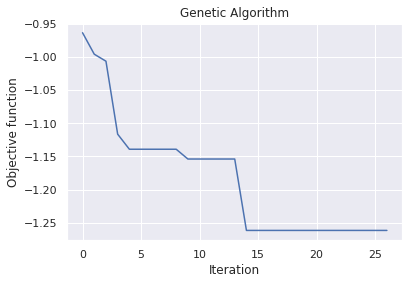


 The best solution found:                                                                           
 [ 27.22833385  50.95187752 103.14934828 112.2916375 ]

 Objective function:
 -1.3997799158096313


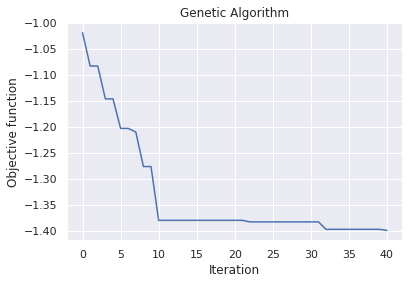

 The best solution found:                                                                           
 [ 14.75657966  50.9185334  101.73012529  95.6825998 ]

 Objective function:
 -1.2364306449890137


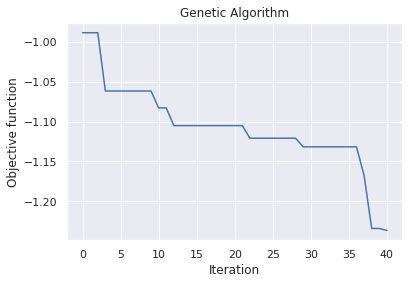

 The best solution found:                                                                           
 [ 18.87780309  49.07843361 103.73531121 112.27482655]

 Objective function:
 -1.71918523311615


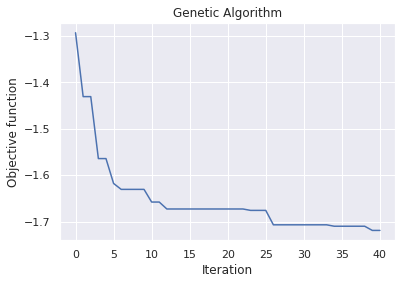

In [92]:
# prescription = {i:{"variable":None, "yield_co2_ratio": None, "yield_pred": None, "co2_pred":None} for i in range(dfX.shape[0])}
for index, row in dfX.iterrows():
    if index <= 368:
        continue
    context = row.to_numpy()[0]
    fun_to_optimize = partial(yield_co2_ratio, context)

    model=ga(function=fun_to_optimize,dimension=4,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)
    model.run()
    
    prescription[index]['variable'] = model.output_dict['variable']
    prescription[index]['yield_co2_ratio'] = model.output_dict['function']
    
    full_features = np.hstack([context,model.output_dict['variable']]).reshape([1,-1])
    
    prescription[index]['yield_pred'] = predict_yield(full_features)
    prescription[index]['co2_pred'] = predict_co2(full_features)

In [93]:
prescription
loaded_prescriptor_data = prescription

In [20]:
import pickle
filehandler = open("prescription_bound_co2_per_yield.pkl","wb")
pickle.dump(prescription,filehandler)

#### Load the saved prescriptor

In [21]:
loaded_prescriptor_data = pickle.load(open('/mnt/CO2Pred/prescription_bound_co2_per_yield.pkl', 'rb'))

In [ ]:
loaded_prescriptor_data[0]

In [94]:
co2_preds, yield_preds, application_dos, nitrogen, phosphorus, potassium = [], [], [], [], [], []
for i in range(len(loaded_prescriptor_data)):
    co2_preds.append(loaded_prescriptor_data[i]['co2_pred'][0][0])
    yield_preds.append(loaded_prescriptor_data[i]['yield_pred'][0][0])
    application_dos.append(loaded_prescriptor_data[i]['variable'][0])
    nitrogen.append(loaded_prescriptor_data[i]['variable'][1])
    phosphorus.append(loaded_prescriptor_data[i]['variable'][2])
    potassium.append(loaded_prescriptor_data[i]['variable'][3])


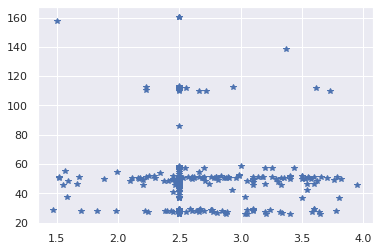

In [95]:
plt.plot(dfX['Soil_Organic_Matter'], nitrogen, '*')
plt.show()

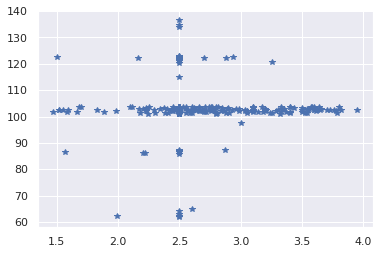

In [96]:
plt.plot(dfX['Soil_Organic_Matter'], phosphorus, '*')
plt.show()

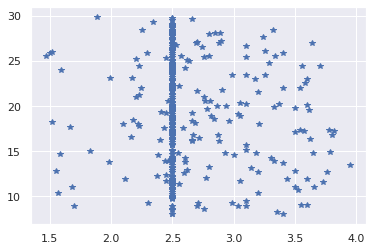

In [97]:
plt.plot(dfX['Soil_Organic_Matter'], application_dos, '*')
plt.show()

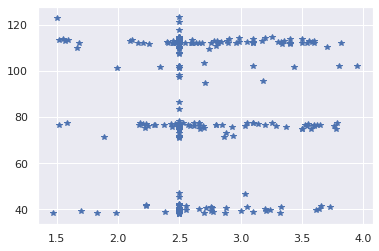

In [98]:
plt.plot(dfX['Soil_Organic_Matter'], potassium, '*')
plt.show()

In [99]:
df['Total_N_pred'] = nitrogen
df['Total_P_pred'] = phosphorus
df['Total_K_pred'] = potassium
df['Application_dos_pred'] = application_dos

In [ ]:
df.head()

### Observe the prescription vs the actual data for the controlled variables

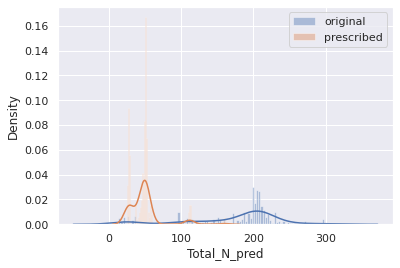

In [101]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.distplot(df.Total_N, bins = n_bins, label = "original")
sns.distplot(df.Total_N_pred, bins = n_bins, label = "prescribed")
ax.legend()
# fig.savefig("/mnt/CO2Pred/fig/" + "N_dist.png", format='png', dpi=800)
plt.show()

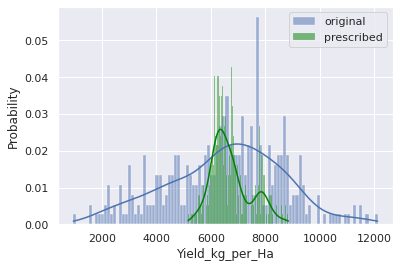

In [106]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.histplot(df.Yield_kg_per_Ha, kde = True, bins = n_bins, stat = 'probability', label = "original")
sns.histplot(yield_preds, kde = True, bins = n_bins, stat = 'probability', label = "prescribed", color = "green")
ax.legend()
# fig.savefig("/mnt/CO2Pred/fig/" + "Yield_dist.png", format='png', dpi=800)
plt.show()

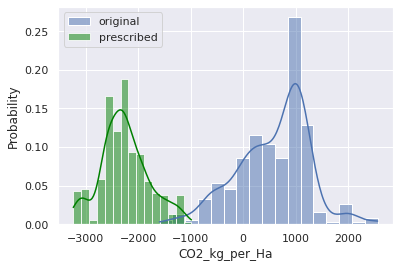

In [107]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.histplot(df.CO2_kg_per_Ha, kde = True, label = "original", stat = 'probability')
sns.histplot(co2_preds, kde = True, label = "prescribed", stat = 'probability', color = "green")
ax.legend()
# fig.savefig("/mnt/CO2Pred/fig" + "CO2_dist600.png", format='png', dpi=600)
plt.show()

In [ ]:
# n_bins = 100
# fig, ax = plt.subplots(1,1)
# sns.distplot(co2_original_predicted, bins = n_bins, label = "original")
# sns.distplot(co2_preds, bins = n_bins, label = "prescribed")
# # ax.set_yscale('log')
# ax.legend()
# plt.show()


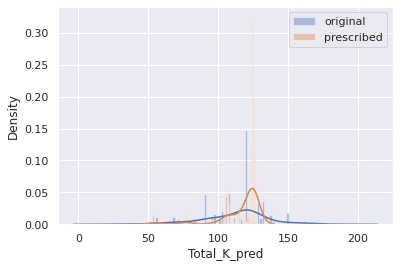

In [37]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.distplot(df.Total_K, bins = n_bins, label = "original")
sns.distplot(df.Total_K_pred, bins = n_bins, label = "prescribed")
ax.legend()
fig.savefig("/mnt/CO2Pred/fig/" + "K_dist.png", format='png', dpi=800)
plt.show()

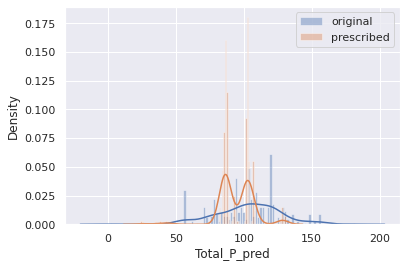

In [38]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.distplot(df.Total_P, bins = n_bins, label = "original")
sns.distplot(df.Total_P_pred, bins = n_bins, label = "prescribed")
ax.legend()
fig.savefig("/mnt/CO2Pred/fig/" + "P_dist.png", format='png', dpi=800)
plt.show()

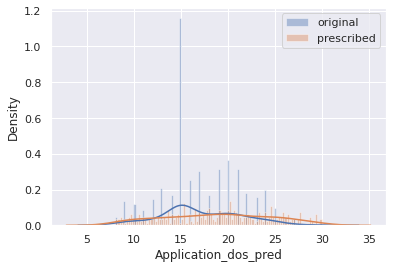

In [39]:
n_bins = 100
fig, ax = plt.subplots(1,1)
sns.distplot(df.Crop_Protection_Application_Doses, bins = n_bins, label = "original")
sns.distplot(df.Application_dos_pred, bins = n_bins, label = "prescribed")
ax.legend()
fig.savefig("/mnt/CO2Pred/fig/" + "app_dose_dist.png", format='png', dpi=800)
plt.show()

#### Observe the yield and co2 predictions

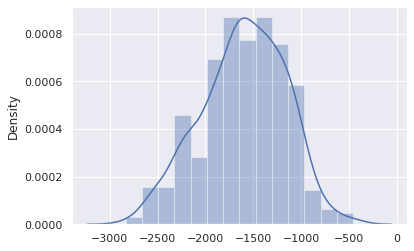

In [40]:
sns.distplot(co2_preds)
plt.show()

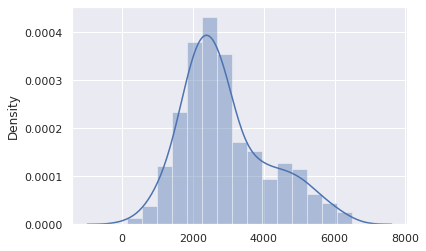

In [41]:
sns.distplot(yield_preds)
plt.show()

In [42]:
# Find Pareto front points
pareto_front = []
for i in range(len(co2_preds)):
    is_pareto_point = True
    for j in range(len(co2_preds)):
        if i != j and co2_preds[j] >= co2_preds[i] and yield_preds[j] >= yield_preds[i]:
            is_pareto_point = False
            break
    if is_pareto_point:
        pareto_front.append({"CO_2 (kg/Ha)": co2_preds[i], "Yield (kg/Ha)": yield_preds[i]})

In [43]:
pareto_front = pd.DataFrame(pareto_front)

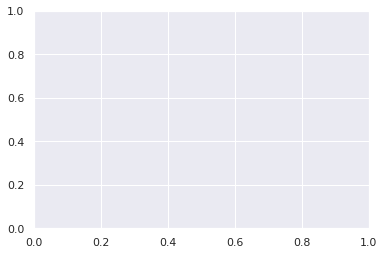

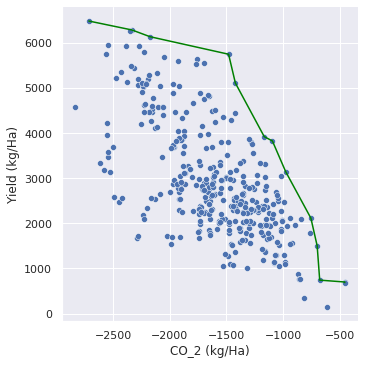

In [44]:
fig, ax = plt.subplots(1,1)
plot = sns.relplot(co2_preds, yield_preds)
plot = sns.lineplot(y = "Yield (kg/Ha)", x = "CO_2 (kg/Ha)", data = pareto_front, color = "green", markers = True)
# fig.savefig("/mnt/CO2Pred/" + "pareto.png", format='png', dpi=800)
plt.show()

fig = plot.get_figure()
fig.savefig("/mnt/CO2Pred/fig/" + "pareto.png", format='png', dpi=800)

In [ ]:
sns.distplot(df.Soil_Organic_Matter)
plt.show()

In [102]:
print(df.Total_N.mean())
print(df.Total_N_pred.mean())
print()
print(df.Total_P.mean())
print(df.Total_P_pred.mean())
print()
print(df.Total_K.mean())
print(df.Total_K_pred.mean())
print()
print(df.Crop_Protection_Application_Doses.mean())
print(df.Application_dos_pred.mean())

172.5968951742628
49.07980192001596

103.52571260053622
102.44545716130719

112.50377479892764
85.46808916144222

17.168900804289546
19.06892283671406


In [55]:
# penguins = sns.load_dataset("penguins")

In [72]:
# penguins

In [ ]:
2